In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/garipov/decomposed/")

In [3]:
import yaml
from yaml import Loader

logdir_i = logdir / "1647855291"

with open(logdir_i / 'config.yml') as yaml_file:
    config_i = yaml.load(yaml_file, Loader=Loader)
config_i

{'baseline_path': '/bigdata/cifar10/logs/garipov/baselines/1647358615/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue/cnn_best.pth',
 'batch': 128,
 'data_dir': '/bigdata/cifar10',
 'data_workers': 8,
 'dataset': 'cifar10',
 'decompose_weights': True,
 'epochs': 10,
 'factorization': 'tucker',
 'gamma': 0,
 'hexsha': '6d9984789338f9cedaf622c602df6aab52f24e83',
 'layers': [6],
 'logdir': '/bigdata/cifar10/logs/garipov/decomposed',
 'lr': 0.0001,
 'model_name': 'gar',
 'momentum': 0.9,
 'optimizer': 'sgd',
 'rank': '0.9',
 'seed': 1647855291,
 't': 1647855291,
 'weight_decay': 0}

In [5]:
import torch

baseline_path = Path('/bigdata/cifar10/logs/garipov/baselines/1647358615/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue')
baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

In [5]:
baseline_model

GaripovNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=1

In [6]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

In [7]:
import os
from pandas import DataFrame

from tddl.post_processing.path_utils import logdir_to_df

df = logdir_to_df(logdir)


In [8]:
g = df.groupby(['factorization','rank','layer']).first()
df2 = g.reset_index()

In [9]:
df_select = df2[
    (df2['factorization'] == 'tucker') &
    (df2['rank'] == 0.5)
]

In [10]:
df_select['layer']

60     2.0
61     4.0
62     6.0
63     8.0
64    10.0
Name: layer, dtype: float64

In [11]:
gar_layers = [0,2,4,6,8,10,11]

In [47]:
from tddl.factorizations import get_weights
from tddl.post_processing.differences import weight_difference
from tddl.plotting.kde import kde_diff
from tddl.plotting.bar import bar_diff

dfs = []
df_diffs = []
for index, row in df_select.iterrows():
    # print(index, row)

    weights_fact = get_weights(torch.load(row['model_fact']), gar_layers)
    weights_best = get_weights(torch.load(row['model_best']), gar_layers)
    weights_final = get_weights(torch.load(row['model_final']), gar_layers)

    layer = int(row['layer'])

    df = weight_difference(weights_fact, weights_final, gar_layers, layer)
    df_diff = df.explode(column='diff',ignore_index=True)

    dfs.append(df)
    df_diffs.append( df.explode(column='diff',ignore_index=True) )

contracted tensor of type: <class 'tltorch.factorized_tensors.factorized_tensors.TuckerTensor'>
contracted tensor of type: <class 'tltorch.factorized_tensors.factorized_tensors.TuckerTensor'>
contracted tensor of type: <class 'tltorch.factorized_tensors.factorized_tensors.TuckerTensor'>
contracted tensor of type: <class 'tltorch.factorized_tensors.factorized_tensors.TuckerTensor'>
contracted tensor of type: <class 'tltorch.factorized_tensors.factorized_tensors.TuckerTensor'>


In [17]:
logdir_model = logdir_i / "gar-lr-[6]-tucker-0.9-dTrue-iNone_bn_128_sgd_l0.0001_g0.0_sTrue" 

model_best = torch.load(logdir_model / "fact_model_best.pth")
model_final = torch.load(logdir_model / "fact_model_final.pth")
model_fact = torch.load(logdir_model / "model_after_fact.pth")

In [26]:
fact_layer = model_fact.conv4
fact_weight = fact_layer.weight
fact_weight.to_tensor()

tensor([[[[ 0.1253,  0.0089, -0.0435],
          [ 0.0376, -0.0912, -0.0849],
          [ 0.0376,  0.0070,  0.0922]],

         [[-0.0506, -0.0985, -0.1663],
          [-0.0899, -0.1560, -0.1895],
          [-0.0374, -0.0198, -0.0537]],

         [[-0.0905, -0.3086, -0.2165],
          [ 0.0851,  0.1019,  0.2302],
          [ 0.3291,  0.1687,  0.1528]],

         ...,

         [[ 0.0721, -0.0049, -0.2600],
          [-0.0457, -0.1225, -0.0891],
          [-0.0118, -0.1567,  0.0395]],

         [[-0.0113,  0.0742, -0.0031],
          [-0.0103,  0.0284, -0.0369],
          [ 0.0504,  0.1370,  0.1435]],

         [[-0.0065, -0.0231, -0.0752],
          [ 0.0046, -0.1841, -0.2740],
          [ 0.0473, -0.2208, -0.1723]]],


        [[[ 0.0538, -0.0669, -0.0031],
          [ 0.0795, -0.0067, -0.0253],
          [ 0.0086, -0.0495, -0.1624]],

         [[-0.0637, -0.0798, -0.0346],
          [-0.0609, -0.1058, -0.1177],
          [ 0.0470, -0.1186, -0.1462]],

         [[ 0.0469, -0.1538, -0

In [9]:
from tddl.factorizations import number_layers, listify_numbered_layers

numbered_layers = number_layers(baseline_model)
numbered_layers

{'conv1': (0,
  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 'conv1_bn': (1,
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'conv2': (2,
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 'conv2_bn': (3,
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'conv3': (4,
  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 'conv3_bn': (5,
  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'conv4': (6,
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 'conv4_bn': (7,
  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'conv5': (8,
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 'conv5_bn': (9,
  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'conv6': (10,
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1),

In [10]:
# loop over layers to get list with the weights

from tddl.factorizations import number_layers, listify_numbered_layers

gar_layers = [0,2,4,6,8,10,11]

def get_weights(model, layer_nrs=[0,6,9,12,15,19,22,25,28,31,35,38,41,44,47,51,54,57,60,63,66]):
    numbered_layers = number_layers(model)
    listed_layers = listify_numbered_layers(numbered_layers=numbered_layers, layer_nrs=layer_nrs)
    return {nr:layer.weight for name,nr,layer in listed_layers}

weights_fact = get_weights(model_fact, [0,2,4,6,8,10,11])
weights_best = get_weights(model_best, [0,2,4,6,8,10,11])
weights_final = get_weights(model_final, [0,2,4,6,8,10,11])

In [40]:
from tensorly import tensor_to_vec
from numpy.linalg import norm
from pandas import DataFrame


def weight_difference(weights_a, weights_b, layer_nrs, fact_nr):

    df = DataFrame(columns=['layer_nr', 'fact_nr', 'norm_2', 'norm_1', 'diff','relative_norm_2','relative_norm_1'])
    for nr in layer_nrs:
        with torch.no_grad():
            diff = (tensor_to_vec(weights_a[nr])-tensor_to_vec(weights_b[nr])).cpu().numpy()
        
            # norm on difference
            norm_2 = norm(diff)
            norm_1 = norm(diff, ord=1)

            relative_norm_2 = norm_2 / norm(tensor_to_vec(weights_a[nr]).cpu().numpy())
            relative_norm_1 = norm_1 / norm(tensor_to_vec(weights_a[nr]).cpu().numpy(), ord=1)

        df = df.append({
            'layer_nr':nr,
            'fact_nr':fact_nr,
            'norm_2':norm_2,
            'norm_1':norm_1,
            'diff': diff,
            'relative_norm_2': relative_norm_2,
            'relative_norm_1': relative_norm_1,
        }, ignore_index=True)

    return df

df = weight_difference(weights_fact, weights_best, gar_layers, config_i['layers'][0])
df_diff = df.explode(column='diff',ignore_index=True)

In [12]:
df

,layer_nr,fact_nr,norm_2,norm_1,diff,relative_norm_2,relative_norm_1
0,0,6,0.014664,0.443604,"[-0.00057964027, -0.00058341026, -0.0006125867...",0.000683,0.000655
1,2,6,0.008366,1.209392,"[5.0139613e-05, 3.7692487e-05, 5.8159232e-05, ...",0.000313,0.000318
2,4,6,0.012519,2.644784,"[1.963973e-05, -3.0368567e-05, -2.2828579e-05,...",0.000348,0.000348
3,6,6,0.501981,148.838974,"[0.000493519, -0.0008897679, -0.000252828, 0.0...",0.011930,0.011751
4,8,6,0.016249,4.655599,"[-2.0503998e-05, -3.8698316e-05, -2.9802322e-0...",0.000366,0.000354
5,10,6,0.009834,2.770458,"[3.952533e-06, -3.6302954e-06, -6.765302e-06, ...",0.000444,0.000478
6,11,6,0.006179,0.162606,"[4.6133995e-05, -0.00024333596, -1.0214746e-05...",0.000655,0.000601


/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


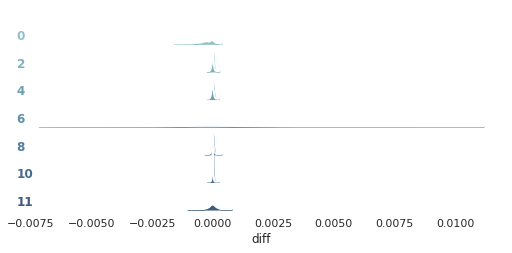

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_diff, row="layer_nr", hue="layer_nr", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "diff",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "diff", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "diff")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

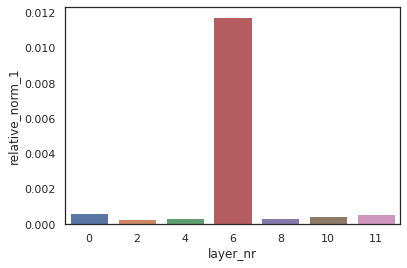

In [22]:
fig = sns.barplot(data=df, x="layer_nr", y="relative_norm_1")
fig.get_figure().savefig('../../plots/gar_c10_difference_relnorm1.pdf')

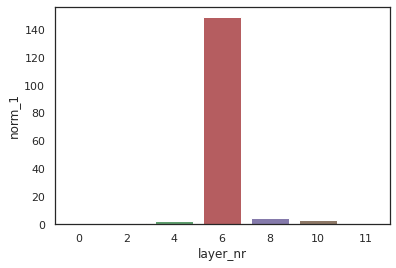

In [23]:
fig = sns.barplot(data=df, x="layer_nr", y="norm_1")
fig.get_figure().savefig('../../plots/gar_c10_difference_norm1.pdf')

In [17]:
df

,layer_nr,fact_nr,norm_2,norm_1,diff,relative_norm_2,relative_norm_1
0,0,6,0.014664,0.443604,"[-0.00057964027, -0.00058341026, -0.0006125867...",0.000683,0.000655
1,2,6,0.008366,1.209392,"[5.0139613e-05, 3.7692487e-05, 5.8159232e-05, ...",0.000313,0.000318
2,4,6,0.012519,2.644784,"[1.963973e-05, -3.0368567e-05, -2.2828579e-05,...",0.000348,0.000348
3,6,6,0.501981,148.838974,"[0.000493519, -0.0008897679, -0.000252828, 0.0...",0.011930,0.011751
4,8,6,0.016249,4.655599,"[-2.0503998e-05, -3.8698316e-05, -2.9802322e-0...",0.000366,0.000354
5,10,6,0.009834,2.770458,"[3.952533e-06, -3.6302954e-06, -6.765302e-06, ...",0.000444,0.000478
6,11,6,0.006179,0.162606,"[4.6133995e-05, -0.00024333596, -1.0214746e-05...",0.000655,0.000601


In [48]:
df_ = pd.concat(dfs)
df_['log_rel_norm_1'] = np.log(df_["relative_norm_1"])

df_pivot = df_.pivot("fact_nr", "layer_nr", "relative_norm_1")
df_pivot_log = df_.pivot("fact_nr", "layer_nr", "log_rel_norm_1")

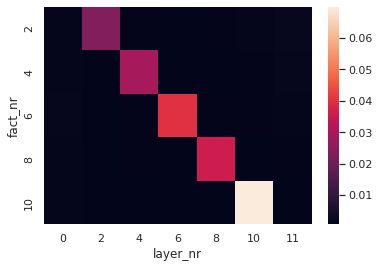

In [49]:
f = sns.heatmap(df_pivot)

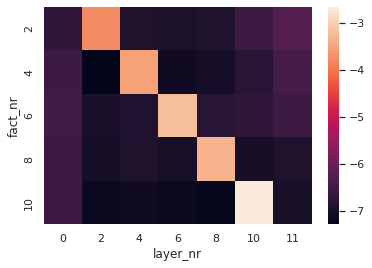

In [51]:
f = sns.heatmap(df_pivot_log)
f.get_figure().savefig('../../plots/gar_c10_difference_heat_contr_log_rel_norm1_final.pdf')